### **Load dataset**

In [1]:
# Upload kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"landaooo","key":"aea06998007bdfa52b69e623c174c352"}'}

In [2]:
# Set up Kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# Download dataset
!kaggle datasets download -d pkdarabi/bone-break-classification-image-dataset
!unzip bone-break-classification-image-dataset.zip -d bone_fracture_dataset

Dataset URL: https://www.kaggle.com/datasets/pkdarabi/bone-break-classification-image-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
  0% 0.00/28.4M [00:00<?, ?B/s]
100% 28.4M/28.4M [00:00<00:00, 441MB/s]
Archive:  bone-break-classification-image-dataset.zip
  inflating: bone_fracture_dataset/Bone Break Classification/Bone Break Classification/Avulsion fracture/Test/000002_png.rf.c3e00ebc2db78bc94e644c3f6605dad0.jpg  
  inflating: bone_fracture_dataset/Bone Break Classification/Bone Break Classification/Avulsion fracture/Test/05cc2e0302957e0ad27edb6b9ffbc2_jumbo_jpg.rf.c15eb3758845b639f3aaba73c373501d.jpg  
  inflating: bone_fracture_dataset/Bone Break Classification/Bone Break Classification/Avulsion fracture/Test/1-s2-0-S0899707114002836-gr2_jpg.rf.bb8ed4dee892edbb760f6ce687d74ba5.jpg  
  inflating: bone_fracture_dataset/Bone Break Classification/Bone Break Classification/Avulsion fracture/Test/13256_2019_2325_Fig1_HTML_png.rf.09368fddb2da3979a35a0cac6f45.jpg  
  infla

In [4]:
import os

base_path = "bone_fracture_dataset"
for root, dirs, files in os.walk(base_path):
    print(f"{root} has {len(dirs)} folders and {len(files)} files")

bone_fracture_dataset has 1 folders and 1 files
bone_fracture_dataset/Bone Break Classification has 1 folders and 0 files
bone_fracture_dataset/Bone Break Classification/Bone Break Classification has 10 folders and 0 files
bone_fracture_dataset/Bone Break Classification/Bone Break Classification/Hairline Fracture has 2 folders and 0 files
bone_fracture_dataset/Bone Break Classification/Bone Break Classification/Hairline Fracture/Test has 0 folders and 10 files
bone_fracture_dataset/Bone Break Classification/Bone Break Classification/Hairline Fracture/Train has 0 folders and 101 files
bone_fracture_dataset/Bone Break Classification/Bone Break Classification/Fracture Dislocation has 2 folders and 0 files
bone_fracture_dataset/Bone Break Classification/Bone Break Classification/Fracture Dislocation/Test has 0 folders and 19 files
bone_fracture_dataset/Bone Break Classification/Bone Break Classification/Fracture Dislocation/Train has 0 folders and 137 files
bone_fracture_dataset/Bone Break

In [5]:
import shutil
import os

# Path to the correct level
fracture_path = "bone_fracture_dataset/Bone Break Classification/Bone Break Classification"

# Create a new directory for combined training
os.makedirs("combined_train", exist_ok=True)

# Loop through each fracture type
for fracture_type in os.listdir(fracture_path):
    full_path = os.path.join(fracture_path, fracture_type, "Train")
    if os.path.isdir(full_path):
        dest = os.path.join("combined_train", fracture_type)
        os.makedirs(dest, exist_ok=True)
        for file in os.listdir(full_path):
            shutil.copy(os.path.join(full_path, file), os.path.join(dest, file))

### **Data Understanding and Preprocessing**

In [6]:
# Set up
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

In [7]:
# Filter out corrupted images

num_skipped = 0
for folder_name in ("Avulsion fracture", "Comminuted fracture", "Fracture Dislocation", "Greenstick fracture", "Hairline Fracture", "Impacted fracture", "Longitudinal fracture", "Oblique fracture", "Pathological fracture", "Spiral Fracture"):
  folder_path = os.path.join("combined_train", folder_name)
  for fname in os.listdir(folder_path):
    fpath = os.path.join(folder_path, fname)
    try:
      fobj = open(fpath, "rb")
      is_jfif = b"JFIF" in fobj.peek(10)
    finally:
      fobj.close()

    if not is_jfif:
      num_skipped += 1
      # Delete corrupted image
      os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 0 images.


In [8]:
# Generate a dataset
image_size = (224,224)
batch_size = 50

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "combined_train",
    validation_split=0.2,
    subset = "both",
    seed = 1337,
    image_size = image_size,
    batch_size = batch_size,
)

Found 989 files belonging to 10 classes.
Using 792 files for training.
Using 197 files for validation.


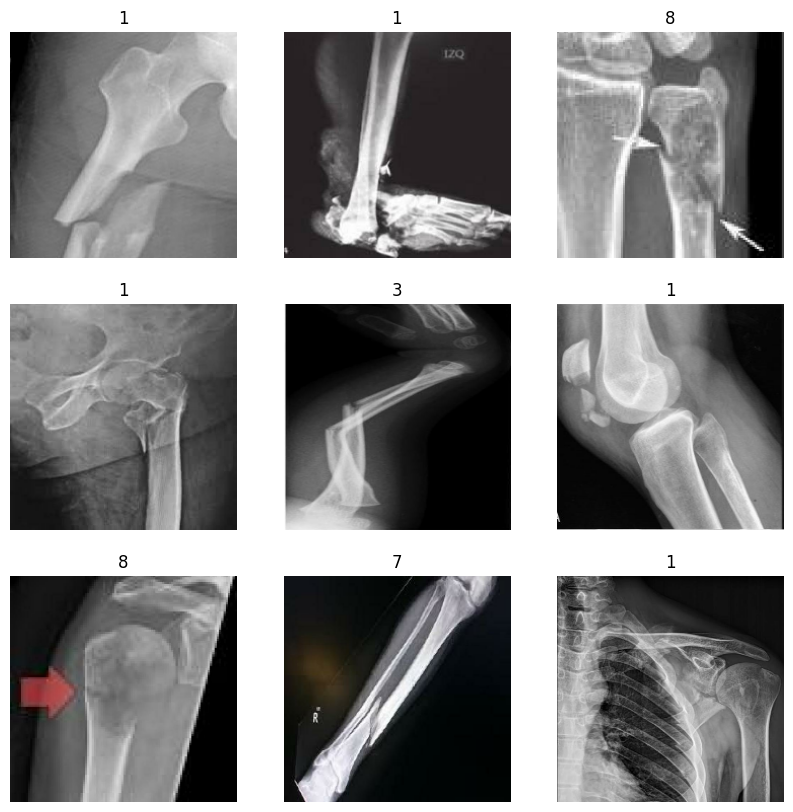

In [9]:
# Visualize the data (select the first 9 images in the training dataset)
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(np.array(images[i]).astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis("off")

In [10]:
# Image data augmentation

data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]

def data_augmentation(images):
  for layer in data_augmentation_layers:
    images = layer(images)
  return images

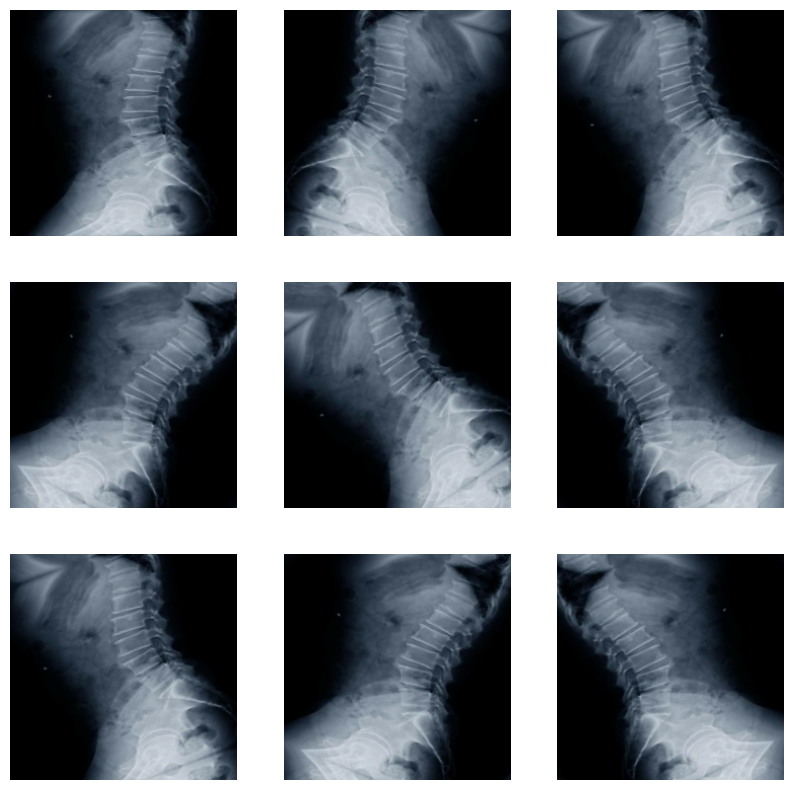

In [11]:
# Visualize the augmented samples
plt.figure(figsize = (10,10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3,3,i+1)
    plt.imshow(np.array(augmented_images[0]).astype("uint8"))
    plt.axis("off")